# PBRM1 proteomics cis comparison

"Involved in transcriptional activation and repression of select genes by chromatin remodeling (alteration of DNA-nucleosome topology). Required for the stability of the SWI/SNF chromatin remodeling complex SWI/SNF-B (PBAF). Acts as a negative regulator of cell proliferation (https://www.uniprot.org/uniprot/Q86U86).

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

## Step 2: Find the frequently mutated genes for Kidney Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [2]:
rc_object = cptac.RenalCcrcc()
desired_cutoff = 0.1

renal_freq_mut = al.get_frequently_mutated(rc_object, cutoff = desired_cutoff)
renal_freq_mut.loc[renal_freq_mut['Gene'] == 'PBRM1']

,Gene,Unique_Samples_Mut,Missense_Mut,Truncation_Mut
2,PBRM1,0.4,0.072727,0.336364


## Step 3: Select PBRM1, a frequently mutated gene

In [3]:
gene = 'PBRM1'

## Step 4: Select proteomics

In [4]:
omics = rc_object.get_proteomics()

## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps.

In [5]:
rc_status = f.format_cis_comparison_data(rc_object, 'proteomics', gene)

In [6]:
omics_col_list = [gene+'_proteomics']
prot_col = gene+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(rc_status, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

         Comparison       P_Value
0  PBRM1_proteomics  1.657330e-10


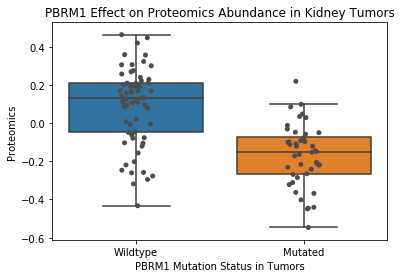

In [7]:
# Step 5 - Create boxplt to compare wildtype and mutated effect on omics data
cis_boxplot = sns.boxplot(data = rc_status, x = 'binary_mutations',
                          y = prot_col, order = ["Wildtype","Mutated"], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Kidney Tumors")
cis_boxplot = sns.stripplot(data= rc_status, x = 'binary_mutations',
                            y = prot_col,jitter = True, color = ".3", order = ["Wildtype","Mutated"])
cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

PBRM1 proteomics decreased in the PBRM1 mutated samples compared to the wildtype.

# Compare missense and truncation mutation types

In [24]:
rc_type = f.get_missence_truncation_comparison(rc_object, 'proteomics', gene)

print("Doing t-test comparison\n")
significant_pval_results = al.wrap_ttest(rc_type, 'binary_mutations', omics_col_list)
print(significant_pval_results)

Doing t-test comparison

No significant comparisons.
None


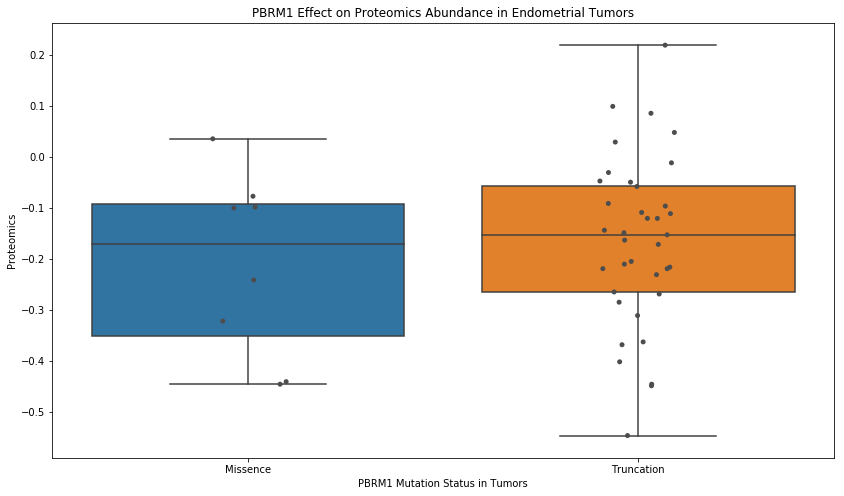

In [25]:
rc_cis_boxplot = sns.boxplot(data = rc_type, x = 'binary_mutations',
                          y = prot_col, order = ["Missence","Truncation"], showfliers = False)  
rc_cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Endometrial Tumors")
rc_cis_boxplot = sns.stripplot(data= rc_type, x = 'binary_mutations',
                            y = prot_col, jitter = True, color = ".3", order = ["Missence","Truncation"])
rc_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

# Compare common mutations

Find the common mutation types and compare them to the wildtype tumors.

In [47]:
# Count all mutations (including all mutations in a sample)
somatic_mutations = rc_object.get_mutations()
gene_mutations = somatic_mutations.loc[somatic_mutations['Gene'] == gene]
count_all_mut = gene_mutations['Mutation'].value_counts()
count_all_mut

Frame_Shift_Del      16
Nonsense_Mutation    14
Missense_Mutation     7
Splice_Site           4
Frame_Shift_Ins       4
In_Frame_Del          2
Name: Mutation, dtype: int64

In [6]:
# count real measurements of omics data 
mutation_prot = rc_object.join_omics_to_mutations(omics_df_name="proteomics",
                                                  mutations_genes=gene, 
                                                  omics_genes=gene)
tumors = mutation_prot.loc[mutation_prot['Sample_Status'] == 'Tumor']                                                  
measured_omics = tumors.dropna(axis=0)
counts = measured_omics[gene+'_Mutation'].value_counts()
counts

[Wildtype_Tumor]                                                                66
[Frame_Shift_Del]                                                               16
[Nonsense_Mutation]                                                             12
[Missense_Mutation]                                                              5
[Frame_Shift_Ins]                                                                4
[Splice_Site]                                                                    4
[In_Frame_Del]                                                                   2
[Nonsense_Mutation, Missense_Mutation, Missense_Mutation, Nonsense_Mutation]     1
Name: PBRM1_Mutation, dtype: int64

In [46]:
common_mutations = count_all_mut[count_all_mut.apply(lambda x: x > 4)] # check mut (have data in more than 1 sample)
print(common_mutations)

common_mut_list = list(common_mutations.index) #list of lists
common_mut_list = [''.join(x) for x in common_mut_list] #list of strings
common_mut_list

Frame_Shift_Del      16
Nonsense_Mutation    14
Missense_Mutation     7
Name: Mutation, dtype: int64


['Frame_Shift_Del', 'Nonsense_Mutation', 'Missense_Mutation']

Most Common Mutation: Frame Shift Deletion

In [48]:
mut_1 = 'Frame_Shift_Del'
mutation_prot_fsd = rc_object.join_omics_to_mutations(omics_df_name="proteomics",
                                                  mutations_genes=gene, 
                                                  omics_genes=gene,
                                                  mutations_filter=[mut_1])
mutation_prot_fsd_tumors = mutation_prot_fsd.loc[mutation_prot_fsd['Sample_Status'] == 'Tumor']
mutation_prot_fsd_tumors[gene+'_Mutation'].value_counts()

Wildtype_Tumor       66
Frame_Shift_Del      16
Nonsense_Mutation    13
Missense_Mutation     5
Splice_Site           4
Frame_Shift_Ins       4
In_Frame_Del          2
Name: PBRM1_Mutation, dtype: int64

In [49]:
# filter: keep only missense and wiltype
binary_mut = mutation_prot_fsd_tumors.query('PBRM1_Mutation == @mut_1 or PBRM1_Mutation == "Wildtype_Tumor"')

#format
formatted_mut_fsd = binary_mut[[gene+'_proteomics', gene+'_Mutation']]

# T-test
print("Doing t-test comparison for", mut_1, "and Wildtype_Tumor\n")
significant_pval_results = al.wrap_ttest(formatted_mut_fsd, gene+'_Mutation', [gene+'_proteomics'])
print(significant_pval_results)

Doing t-test comparison for Frame_Shift_Del and Wildtype_Tumor

         Comparison   P_Value
0  PBRM1_proteomics  0.000089


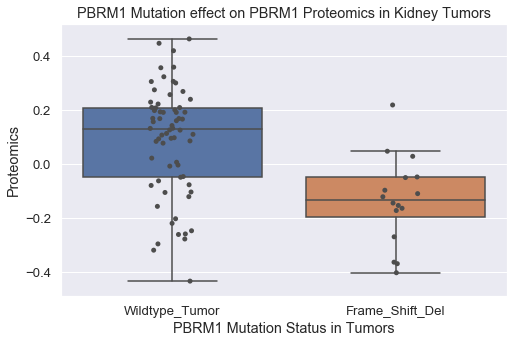

In [50]:
plt.rcParams['figure.figsize']=(8,5)
sns.set(font_scale = 1.2)
rc_cis_boxplot = sns.boxplot(data = formatted_mut_fsd,
                             x = gene+'_Mutation',
                             y = gene+'_proteomics', 
                             showfliers = False)  
rc_cis_boxplot.set_title(gene + " Mutation effect on "+gene+" Proteomics in Kidney Tumors")
rc_cis_boxplot = sns.stripplot(data= formatted_mut_fsd, 
                               x = gene+'_Mutation',
                               y = gene+'_proteomics', 
                               jitter = True, color = ".3")
rc_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()
plt.clf()
plt.close()

2. Nonsense Mutation

In [27]:
mut_2 = 'Nonsense_Mutation'
mutation_prot_ns = rc_object.join_omics_to_mutations(omics_df_name="proteomics",
                                                  mutations_genes=gene, 
                                                  omics_genes=gene,
                                                  mutations_filter=[mut_2])
mutation_prot_ns_tumors = mutation_prot_ns.loc[mutation_prot_fsd['Sample_Status'] == 'Tumor']
#mutation_prot_fsd_tumors[gene+'_Mutation'].value_counts()

In [29]:
# filter: keep only missense and wiltype
binary_mut = mutation_prot_ns_tumors.query('PBRM1_Mutation == @mut_2 or PBRM1_Mutation == "Wildtype_Tumor"')

#format
formatted_mut_ns = binary_mut[[gene+'_proteomics', gene+'_Mutation']]

# T-test
print("Doing t-test comparison for", mut_2, "and Wildtype_Tumor\n")
significant_pval_results = al.wrap_ttest(formatted_mut_ns, gene+'_Mutation', [gene+'_proteomics'])
print(significant_pval_results)

Doing t-test comparison for Nonsense_Mutation and Wildtype_Tumor

         Comparison   P_Value
0  PBRM1_proteomics  0.000004


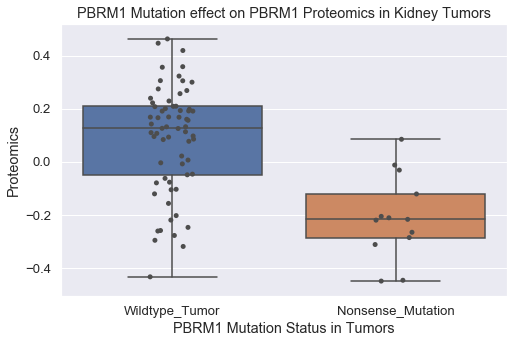

In [37]:
plt.rcParams['figure.figsize']=(8,5)
sns.set(font_scale = 1.2)
rc_cis_boxplot = sns.boxplot(data = formatted_mut_ns,
                             x = gene+'_Mutation',
                             y = gene+'_proteomics', 
                             order = ['Wildtype_Tumor', mut_2],
                             showfliers = False)  
rc_cis_boxplot.set_title(gene + " Mutation effect on "+gene+" Proteomics in Kidney Tumors")
rc_cis_boxplot = sns.stripplot(data= formatted_mut_ns, 
                               x = gene+'_Mutation',
                               y = gene+'_proteomics', 
                               order = ['Wildtype_Tumor', mut_2],
                               jitter = True, color = ".3")
rc_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()
plt.clf()
plt.close()

3. Missense Mutation     

In [33]:
mut_3 = 'Missense_Mutation'
mutation_prot_miss = rc_object.join_omics_to_mutations(omics_df_name="proteomics",
                                                  mutations_genes=gene, 
                                                  omics_genes=gene,
                                                  mutations_filter=[mut_3])
mutation_prot_miss_tumors = mutation_prot_miss.loc[mutation_prot_miss['Sample_Status'] == 'Tumor']
mutation_prot_miss_tumors[gene+'_Mutation'].value_counts()

Wildtype_Tumor       66
Frame_Shift_Del      16
Nonsense_Mutation    12
Missense_Mutation     6
Splice_Site           4
Frame_Shift_Ins       4
In_Frame_Del          2
Name: PBRM1_Mutation, dtype: int64

In [34]:
# filter: keep only missense and wiltype
binary_mut = mutation_prot_miss_tumors.query('PBRM1_Mutation == @mut_3 or PBRM1_Mutation == "Wildtype_Tumor"')

#format
formatted_mut_miss = binary_mut[[gene+'_proteomics', gene+'_Mutation']]

# T-test
print("Doing t-test comparison for", mut_3, "and Wildtype_Tumor\n")
significant_pval_results = al.wrap_ttest(formatted_mut_miss, gene+'_Mutation', [gene+'_proteomics'])
print(significant_pval_results)

Doing t-test comparison for Missense_Mutation and Wildtype_Tumor

         Comparison   P_Value
0  PBRM1_proteomics  0.000052


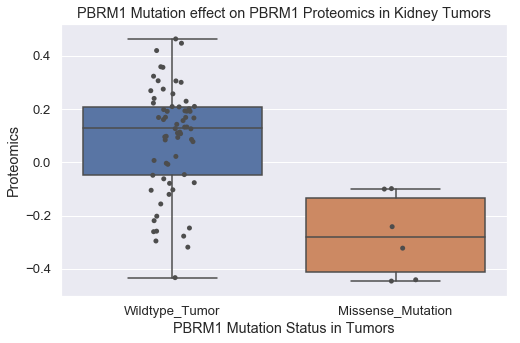

In [38]:
plt.rcParams['figure.figsize']=(8,5)
sns.set(font_scale = 1.2)
rc_cis_boxplot = sns.boxplot(data = formatted_mut_miss,
                             x = gene+'_Mutation',
                             y = gene+'_proteomics', 
                             showfliers = False)  
rc_cis_boxplot.set_title(gene + " Mutation effect on "+gene+" Proteomics in Kidney Tumors")
rc_cis_boxplot = sns.stripplot(data= formatted_mut_miss, 
                               x = gene+'_Mutation',
                               y = gene+'_proteomics', 
                               jitter = True, color = ".3")
rc_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()
plt.clf()
plt.close()

# Visualize all Mutations

In [39]:
mutation_prot = rc_object.join_omics_to_mutations(omics_df_name="proteomics", mutations_genes=gene, 
                                                        omics_genes=gene,
                                                    mutations_filter=['Nonsense_Mutation'])

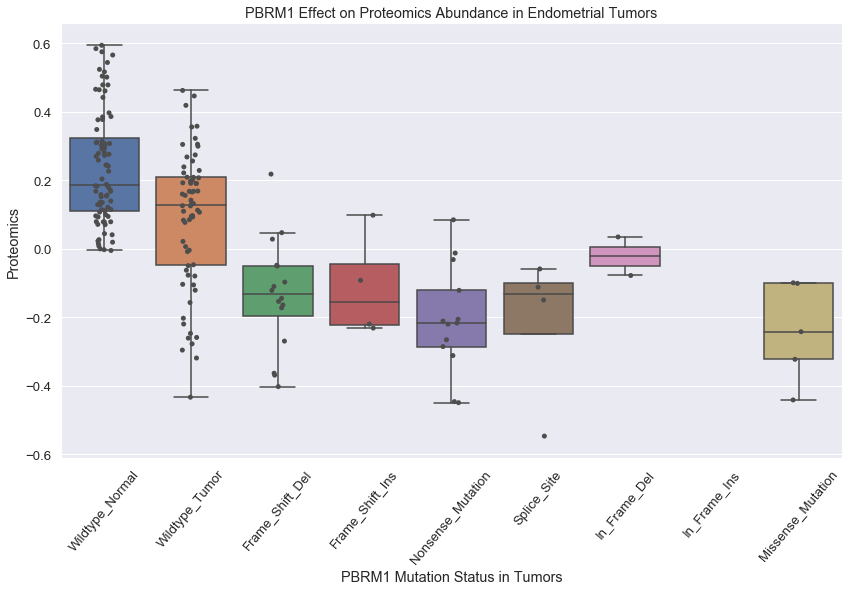

In [41]:
plt.rcParams['figure.figsize']=(14,8)
rc_cis_boxplot = sns.boxplot(data = mutation_prot,
                             x = gene+'_Mutation',
                             y = gene+'_proteomics', 
                             order=['Wildtype_Normal', 'Wildtype_Tumor', 'Frame_Shift_Del', 
                                    'Frame_Shift_Ins', 'Nonsense_Mutation', 'Splice_Site',
                                    'In_Frame_Del', 'In_Frame_Ins', 'Missense_Mutation'],
                             showfliers = False)  
rc_cis_boxplot.set_title(gene + " Effect on Proteomics Abundance in Endometrial Tumors")
rc_cis_boxplot = sns.stripplot(data= mutation_prot, 
                               x = gene+'_Mutation',
                               y = gene+'_proteomics', 
                               order=['Wildtype_Normal', 'Wildtype_Tumor', 'Frame_Shift_Del', 
                                    'Frame_Shift_Ins', 'Nonsense_Mutation', 'Splice_Site',
                                    'In_Frame_Del', 'In_Frame_Ins', 'Missense_Mutation'],
                               jitter = True, color = ".3")
rc_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
rc_cis_boxplot.set_xticklabels(rc_cis_boxplot.get_xticklabels(),rotation = 50)
plt.show()
plt.clf()
plt.close()

# Analysis of Results

PBRM1 proteomics decreased in the PBRM1 mutated samples compared to the wildtype. Two significant common truncations (nonsense and frame shift del) also showed a decrease in PBRM1 proteomics.